In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from scipy.stats import norm

In [12]:
# DimEstWav/DimEst_boot.m
def DimEst_boot(Y, NREP, B, p, N, wname):
    """
    Python translation of MATLAB DimEst_boot.

    Parameters
    ----------
    Y : array (nt x n)
        Functional observations
    NREP : int
        Number of bootstrap replications
    B : array (J x d0)
        Eigenvector matrix (wavelet coefficients of estimated eigenfunctions)
    p : int
        Maximum lag
    N : int
        Wavelet decomposition level
    wname : str
        Wavelet name (e.g. 'db2')

    Returns
    -------
    vd0p1_boot : array (NREP,)
        Bootstrap estimates of eigenvalue_{d0+1}
    """

    J, d0 = B.shape
    nt, n = Y.shape

    vd0p1_boot = np.zeros(NREP)
    Yhat = np.zeros((nt, n))
    H = np.zeros((nt, d0))
    A = np.zeros((J, n))
    Yboot = np.zeros((nt, n))
    Aboot = np.zeros((J, n))

    # =====================================================================
    # Compute wavelet decomposition of Y
    # =====================================================================
    # Get coefficient slicing lengths using first column
    coeffs0 = pywt.wavedec(Y[:, 0], wname, level=N)
    lengths = [len(c) for c in coeffs0]

    for ii in range(n):
        coeffs = pywt.wavedec(Y[:, ii], wname, level=N)
        A[:, ii] = np.concatenate(coeffs)

    mu_A = A.mean(axis=1, keepdims=True)
    C = A - mu_A

    # =====================================================================
    # Reconstruct mean function using inverse wavelet transform
    # =====================================================================
    def waverec_from_vector(v):
        out = []
        idx = 0
        for L in lengths:
            out.append(v[idx:idx+L])
            idx += L
        return pywt.waverec(out, wname)

    mu_hat = waverec_from_vector(mu_A[:, 0])

    # =====================================================================
    # Reconstruct eigenfunctions H(:,k)
    # =====================================================================
    for ii in range(d0):
        H[:, ii] = waverec_from_vector(B[:, ii])

    # =====================================================================
    # Compute fitted curves Yhat
    # =====================================================================
    for ii in range(n):
        Yhat[:, ii] = mu_hat.copy()
        for k in range(d0):
            coef = C[:, ii].T @ B[:, k]   # inner product
            Yhat[:, ii] += coef * H[:, k]

    mEps_hat = Y - Yhat

    # =====================================================================
    # Bootstrap replications
    # =====================================================================
    for jj in range(NREP):

        # Resample residual curves with replacement
        for ii in range(n):
            idx = np.random.randint(0, n)
            Yboot[:, ii] = Yhat[:, ii] + mEps_hat[:, idx]

            coeffs = pywt.wavedec(Yboot[:, ii], wname, level=N)
            Aboot[:, ii] = np.concatenate(coeffs)

        mu_Aboot = Aboot.mean(axis=1, keepdims=True)
        Cb = Aboot - mu_Aboot

        C1 = Cb[:, :n-p]
        D1 = np.zeros((n-p, n-p))

        for k in range(1, p+1):
            Ct = Cb[:, k:(n-p+k)]
            D1 += Ct.T @ Ct

        Dboot = C1 @ D1 @ C1.T / ((n - p)**2)

        # eigen-decomposition
        Lboot, Bboot = np.linalg.eig(Dboot)

        # MATLAB takes Lboot(d0+1,d0+1), but eigenvalues are unordered.
        # We sort them descending to match MATLAB's behavior.
        L_sorted = np.sort(Lboot)[::-1]

        vd0p1_boot[jj] = L_sorted[d0]

    return vd0p1_boot

In [13]:
def wavedec_sizes(signal_length, wavelet_name, level):
    """
    Compute expected pywt.wavedec sizes:
      returns sizes = [len(A_N), len(D_N), ..., len(D_1)]
      and total = sum(sizes)
    """
    w = pywt.Wavelet(wavelet_name)
    F = w.dec_len
    L = signal_length

    lengths = []
    Lj = L
    for j in range(level):
        Lj = (Lj + F - 1) // 2
        lengths.append(Lj)

    sizes = [lengths[-1]] + lengths[::-1]

    total = sum(sizes)
    return sizes, total

In [14]:
from typing import Tuple
def WdFPC(
        Y: np.ndarray,
        nt: int,
        N: int = 3,
        wavelet_: str = 'db2',
        p = 5
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute Wavelet-domain Functional Principal Components (WdFPC)
    for a sample of functional data.

    Parameters
    ----------
    Y : np.ndarray
        Functional observations of shape (nt, n), where:
        - nt is the number of grid points for each curve.
        - n  is the number of curves.
        Each column Y[:, i] is one function sampled on a common grid.

    nt : int
        Number of grid points of the functional domain.
        Must match Y.shape[0].

    N : int, default=3
        Wavelet decomposition level used in the discrete wavelet transform
        (DWT). Higher values give coarser approximations.

    wavelet : str, default='db2'
        Wavelet family to use for the DWT. Must be any valid PyWavelets
        wavelet name (e.g., 'db2', 'haar', 'coif1', ...).

    p : int, default=5
        Number of lags for the covariance operator.

    Returns
    -------
    L : np.ndarray
        Eigenvalues of the estimated covariance operator in the wavelet
        domain, sorted in decreasing order. Shape: (J,).

    B : np.ndarray
        Corresponding eigenvectors (principal directions) in the wavelet
        coefficient space. Shape: (J, J), where J is the total number of
        stacked wavelet coefficients.

    Notes
    -----
    - The function uses the **stacked wavelet coefficients** of each curve
      as features, following the methodology of wavelet-domain PCA.

    - The sample size `n` is inferred from `Y.shape[1]`.

    - The returned eigenvectors B span the wavelet coefficient space, not
      the original functional domain.

    - The temporal dependence structure is incorporated by forming a
      lagged autocovariance estimator using p=5 lags.

    - The function assumes Y has no missing values and is properly aligned
      on a common grid.
    """
        
    n = Y.shape[1]  # infer sample size from data

    # compute total number of stacked DWT coefficients
    sizes, total = wavedec_sizes(nt, wavelet_, N)
    J = total

    # matrix of DWT coefficient vectors
    A = np.zeros((J, n))

    for ii in range(n):
        coeffs = pywt.wavedec(Y[:, ii], wavelet=wavelet_, level=N)
        A[:, ii] = np.concatenate(coeffs)

    # mean-adjust coefficients
    mu_A = np.mean(A, axis=1, keepdims=True)
    C = A - mu_A

    # compute lagged covariance operator estimate
    C1 = C[:, :n - p]
    D1 = np.zeros((n - p, n - p))

    for k in range(1, p + 1):
        Ct = C[:, k:(n - p + k)]
        D1 += Ct.T @ Ct

    D = C1 @ D1 @ C1.T / ((n - p) ** 2)

    # eigendecomposition
    L, B = np.linalg.eig(D)

    # sort eigenvalues descending
    idx = np.argsort(-L)

    return L[idx], B[:, idx]

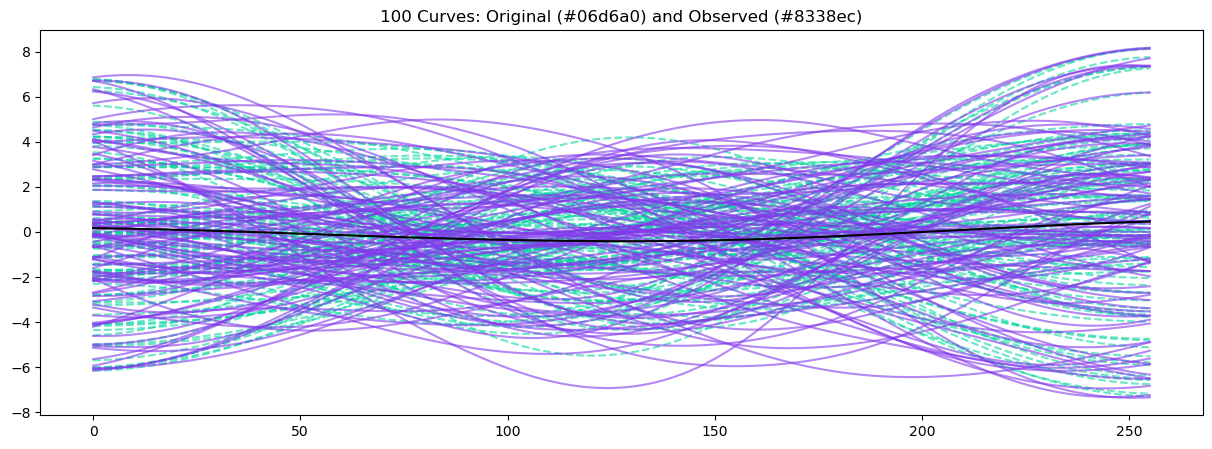

In [15]:
# Simulação


# ==========================================================
# PARAMETERS
# ==========================================================
n = 100          # sample size (curves)
d = 2            # dimension parameter
nt = 256         # number of grid points
u = np.linspace(0.01, 0.99, nt)[:, None]  # nt x 1 grid
N = 3            # wavelet decomposition level

# ==========================================================
# ARIMA PROCESSES FOR UNOBSERVED FUNCTIONAL DYNAMICS
# ==========================================================


def simulate_ar1(phi, n, sigma2=1.5):
    x = np.zeros(n)
    eps = np.random.normal(scale=np.sqrt(sigma2), size=n)
    for t in range(1, n):
        x[t] = phi * x[t-1] + eps[t]
    return x

# simulate processes
xi1 = simulate_ar1(-0.65, n)
xi2 = simulate_ar1( 0.40, n)

# ==========================================================
# GENERATE UNOBSERVED FUNCTIONAL DATA X(t)
# ==========================================================
X = np.zeros((nt, n))

for ii in range(n):
    X[:, ii] = (
        xi1[ii] * np.sqrt(2) * np.cos(np.pi * u[:, 0]) +
        xi2[ii] * np.sqrt(2) * np.cos(2 * np.pi * u[:, 0])
    )


# ==========================================================
# ADD NOISE USING SINE SERIES
# ==========================================================
mEps = np.zeros((nt, n))

for ii in range(n):
    for jj in range(1, 11):
        mEps[:, ii] += (
            norm.rvs(scale=1.0) * np.sqrt(2) *
            np.sin(np.pi * u[:, 0] * jj) / (2 ** (jj - 1))
        )


# ==========================================================
# OBSERVED FUNCTIONAL DATA
# ==========================================================
Y = X + mEps


plt.figure(figsize=(15,5))


color_original = "#06d6a0"
plt.plot(X, alpha=.6, c=color_original, linestyle="--",label="Unobserved")

color_observed = "#8338ec"
plt.plot(Y, alpha=.6, c=color_observed, label="Observed")

plt.plot(np.mean(Y,axis=1), c="black")

plt.title(f"{n} Curves: Original ({color_original}) and Observed ({color_observed})")

plt.show()

In [16]:
n = 100          # sample size (curves)
d = 2            # dimension parameter
nt = 256         # number of grid points
u = np.linspace(0.01, 0.99, nt)[:, None]  # nt x 1 grid
N = 3            # wavelet decomposition level

eigenvalues_B, eigenvectors_B = WdFPC(Y, nt, N)

c:\Users\user\anaconda3\envs\densities4risk\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\user\anaconda3\envs\densities4risk\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


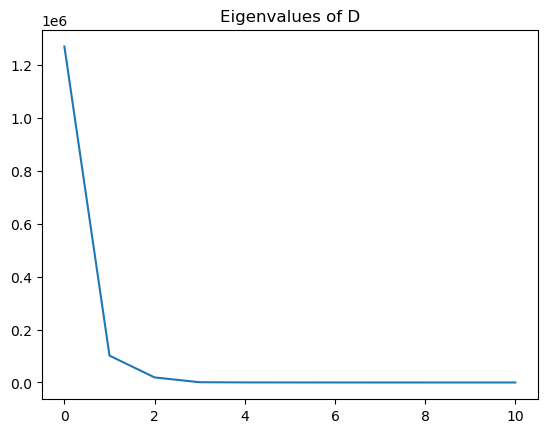

In [17]:
plt.figure()

plt.plot(eigenvalues_B[:11])

plt.title("Eigenvalues of D")

plt.show()

In [18]:
# proportion of the total eigenvalue mass contained in the first 4 eigenvalues
print(np.linalg.norm(eigenvalues_B[:4], 1) / np.linalg.norm(eigenvalues_B, 1))

0.9997118719234962


In [ ]:
#C:\Users\user\Projetos\densities4risk\resources\wavelet_estimation_fonseca\Fertilidade_Australia\03\Autralia_Fert_Rate_WavDimEst.m

# h1_hat =  waverec(B(:,1),Lw,wname);
# h2_hat =  waverec(B(:,2),Lw,wname);
# h3_hat =  waverec(B(:,3),Lw,wname);
# h4_hat =  waverec(B(:,4),Lw,wname);
# h5_hat =  waverec(B(:,5),Lw,wname);


# p = 5;  % lag máximo utilizado
# vw = [.1,.3,.5]'; % vetor de pesos
# %vw = vw/norm(vw);
# delta = length(vw); % número de pesos usados
# nt = 1000;  % número de pontos usados para cada ano
# u = linspace(13,52,nt);  % nt valores igualmente espaçados de 13 a 52
# du = u(2) - u(1);
# SmoLogFertRate = zeros(nt,n);
# for k=2:91
#     fspl = fit(logFerRate(2:10,1),logFerRate(2:10,k),'smoothingspline');
#     SmoLogFertRate(:,(k-1)) = fspl(u);
# end

# % esse vetor terá a média de um determinado coeficiente
# % ao longo dos n dias
# mu_dec = mean(SmoLogFertRate,2);

# % matriz com os desvios dos coeficientes em relação à
# % média dos coeficientes num mesmo dia
# C = SmoLogFertRate - mu_dec*ones(1,n);

# % funcional observado centrado
# mat_G = du*(C'*C);

# % matriz com os produtos internos dos funcionais centrados multiplicados
# % pelos pesos
# Zk = zeros(n-p-delta+1,n-p-delta+1,p-delta+1);
# for k=delta:(p-delta+1)
#     mat_Z = FuncMatProdYcentAggregVet( C, vw, p, k);
#     Zk(:,:,k) = du*mat_Z;
# end